In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state
from flax.core.frozen_dict import freeze, unfreeze

!git clone https://github.com/htymjun/da-sr
os.chdir('/content/da-sr')

from read import fw_to_np

Cloning into 'da-sr'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 52 (delta 25), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (52/52), 10.02 MiB | 7.30 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [2]:
# read cn and fw files
u, v, w, p, t, icount, x, y, z = fw_to_np('data')
# interpolate
uc = 0.5e0*(u[:-1,:,:]+u[1:,:,:])
vc = 0.5e0*(v[:,:-1,:]+v[:,1:,:])
wc = 0.5e0*(w[:,:,:-1]+w[:,:,1:])
xc = 0.5e0*(x[:-1]+x[1:])
yc = 0.5e0*(y[:-1]+y[1:])
zc = 0.5e0*(z[:-1]+z[1:])

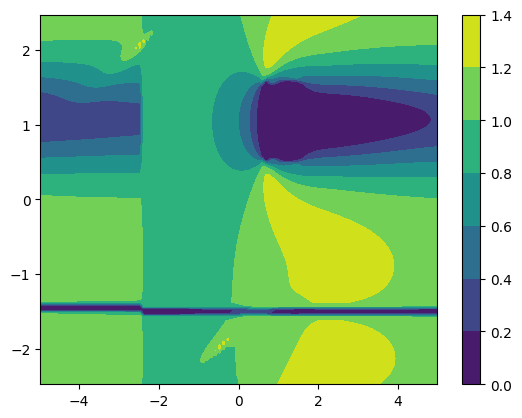

In [3]:
Nz = int(0.5*len(zc))
U = np.sqrt(uc[:,:,Nz]**2+vc[:,:,Nz]**2)
Xc, Yc = np.meshgrid(xc,yc)

fig, ax = plt.subplots()
tcf = ax.contourf(Xc, Yc, np.transpose(U))
fig.colorbar(tcf)

In [4]:
# set_batch
Nx = 20
Ny = 20
ub = uc[:,:,Nz].reshape(-1,Nx,Ny)
vb = vc[:,:,Nz].reshape(-1,Nx,Ny)
x = np.stack([ub,vb], axis=-1)

# normalize
N = len(x[:,0,0,0])
ave = np.zeros(N)
for i in range(N):
  ave[i] = 0.5e0*(x[i,:,:,0].mean()+x[i,:,:,1].mean())
  x[i,:,:,0] = np.divide(x[i,:,:,0],ave[i])
  x[i,:,:,1] = np.divide(x[i,:,:,1],ave[i])

In [53]:
class CNN(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=64,kernel_size=(3,3),strides=(1,1),padding='SAME')(x)
    x = nn.relu(x)
    #x = nn.max_pool(x,window_shape=(2,2), strides=(2,2), padding='VALID')

    x = nn.Conv(features=32,kernel_size=(3,3),strides=(1,1),padding='SAME')(x)
    x = nn.relu(x)
    #x = nn.max_pool(x,window_shape=(2,2), strides=(2,2), padding='VALID')

    x = nn.Conv(features=2,kernel_size=(3,3),strides=(1,1),padding='SAME')(x)
    return x

In [54]:
# initialize model
key = random.PRNGKey(0)
model = CNN()

params = model.init(key,jnp.ones_like(x)) # x(batch,height,width,channel)

# calc convolution
output = model.apply(params,x)

In [55]:
print(x.shape)
print(output.shape)
print(output[1,:,:,1])

(50, 20, 20, 2)
(50, 20, 20, 2)
[[ 2.05059037e-01  5.04411519e-01  4.11232591e-01  2.13247910e-01
   2.09267050e-01  2.74189115e-01  2.96754777e-01  3.08541596e-01
   3.18302989e-01  3.22932869e-01  3.21509838e-01  3.17932665e-01
   3.12110841e-01  3.02520037e-01  2.90185004e-01  2.78251201e-01
   2.69397110e-01  3.97992134e-01  3.84685904e-01  8.09538513e-02]
 [ 4.83505815e-01  4.21884447e-01  6.99264407e-01  9.24471736e-01
   1.17931342e+00  1.09175551e+00  1.06166816e+00  1.04054487e+00
   1.02128446e+00  1.00163281e+00  9.86160219e-01  9.74053621e-01
   9.62988496e-01  9.55938101e-01  9.56386030e-01  9.63664293e-01
   9.85905647e-01  9.87419486e-01  6.53090358e-01  4.53774333e-02]
 [ 9.45702046e-02  7.69375637e-02  9.49061871e-01  9.53408778e-01
   1.13591981e+00  1.13471639e+00  1.14879143e+00  1.17084181e+00
   1.19619799e+00  1.21758699e+00  1.23174262e+00  1.23682475e+00
   1.23488069e+00  1.22344089e+00  1.19379103e+00  1.14791644e+00
   1.07342839e+00  8.03747177e-01  7.47152

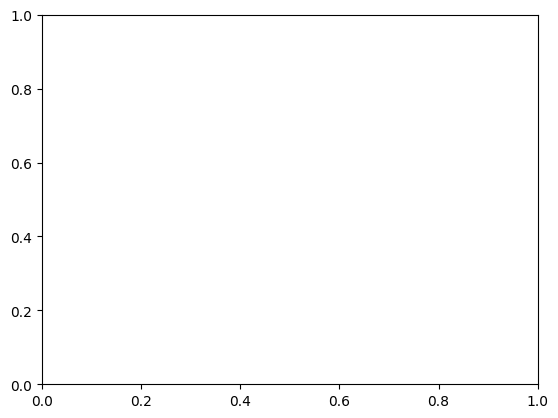

In [46]:
# visualize
Xc, Yc = np.meshgrid(np.linspace(0,1,len(x[0,:,0,0])),np.linspace(0,1,len(x[0,0,:,0])))

fig, axes = plt.subplots()
tcf = ax.contourf(Xc, Yc, x[0,:,:,1])
ax.set_aspect('equal')